In [17]:
import pickle
import numpy as np
import pandas as pd
from keras import models
from keras.layers import Dense, Concatenate, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
import time
import os
import sys
import CNN_functions as CNNFuncs

In [18]:
model_mode = "ccRCC"
model_name = "1"

In [19]:
model = models.load_model("models/{0}/{1}/model.h5".format(model_mode, model_name))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 500)               4002000   
                                                                 
 dense_10 (Dense)            (None, 300)               150300    
                                                                 
 dense_11 (Dense)            (None, 150)               45150     
                                                                 
 dense_12 (Dense)            (None, 75)                11325     
                                                                 
 dense_13 (Dense)            (None, 500)               38000     
                                                                 
 dense_14 (Dense)            (None, 500)               250500    
                                                                 
 dense_15 (Dense)            (None, 500)              

In [20]:
model_info = dict(pd.read_csv("models/{0}/{1}/model_info.csv".format(model_mode, model_name)).to_numpy())

test_size = float(model_info["test_size"])
random_state = int(model_info["random_state"])
model_mode = model_info["model_mode"]
extract_genes_no = int(model_info["extract_genes_no"])
extract_neg_selec = True if model_info["extract_neg_selec"] == "True" else False
dense_layer_dim = float(model_info["dense_layer_dim"])
l2_reg = float(model_info["l2_reg"])
num_epoch = float(model_info["num_epoch"])

In [21]:
model_datasets, tRCC_datasets, essential_genes = CNNFuncs.preprocess_data(test_size=test_size,
                                                                          random_state=random_state,
                                                                          mode=model_mode,
                                                                          extract_top_genes=extract_genes_no,
                                                                          extract_neg_selec=extract_neg_selec)

X_train = model_datasets[0]
Y_train = model_datasets[2]

X_test = model_datasets[1]
Y_test = model_datasets[3]

tRCC_gene_exp = tRCC_datasets[0]
tRCC_gene_effect = tRCC_datasets[1]

top100_essential_genes = essential_genes["top100_essential_genes"]
top_common_essential_genes = essential_genes["common_essential_genes"]

DepMap dataset row/column check:  {'all_match': True, 'column_differences': [[], []], 'row_differences': [[], []]}
tRCC dataset row/column check:  {'all_match': True, 'column_differences': [[], []], 'row_differences': [[], []]}
Check columns across DepMap and tRCC dataframes:  {'all_match': True, 'column_differences': [[], [], [], []]}


## Model Mode Test Dataset

In [22]:
predictions = pd.DataFrame(model.predict(X_test), columns=X_test.columns, index=X_test.index)

1/1 [==============================] - 0s 35ms/step


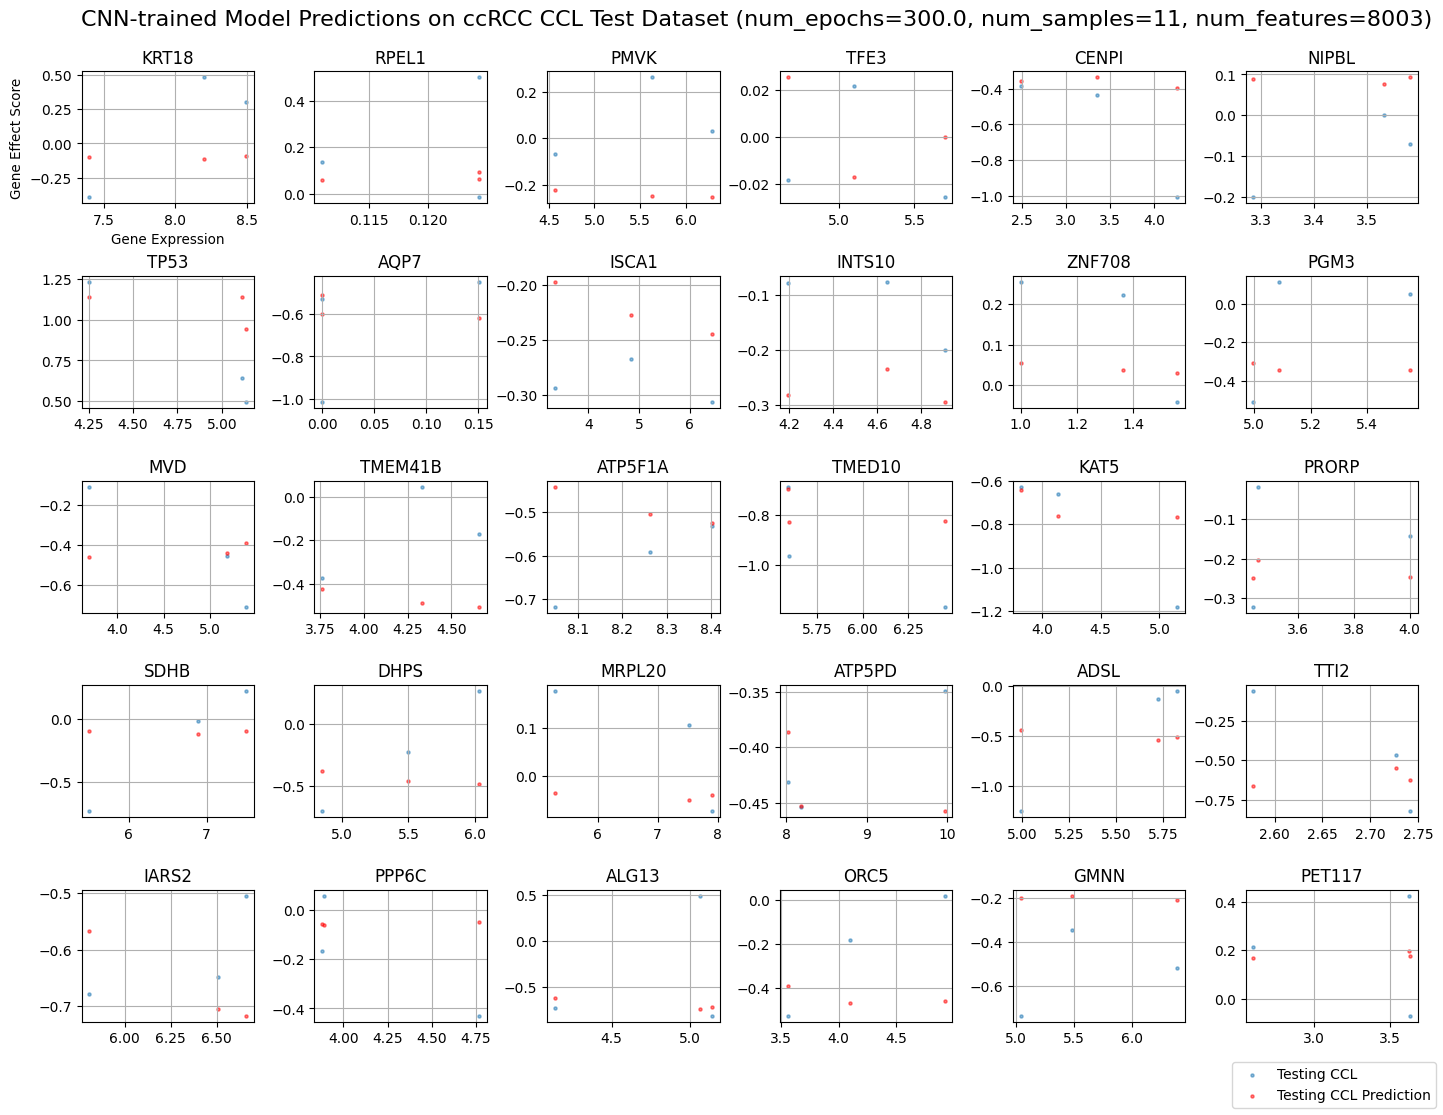

In [23]:
CNNFuncs.GeneRelMiniPlot(X_test, Y_test, top100_essential_genes[:30].to_list(),
                         rel2_X=X_test,
                         rel2_Y=predictions,
                         main_title="CNN-trained Model Predictions on {0} CCL Test Dataset (num_epochs={1}, num_samples={3}, num_features={2})".format(model_mode, num_epoch, X_train.shape[1], X_train.shape[0]),
                         axes_labels=["Gene Expression", "Gene Effect Score"],
                         axis_label_fontsize=9.75,
                         legend_titles={"rel1": "Testing CCL", "rel2": "Testing CCL Prediction"},
                                        sizeProps=[0.925, 0.08, 0.99, 0],
                                        wspace=0.35,
                                        hspace=0.55)

In [24]:
pred_RMSE_top100_essential_genes = CNNFuncs.PredGeneRMSE(Y_test, predictions, top100_essential_genes)

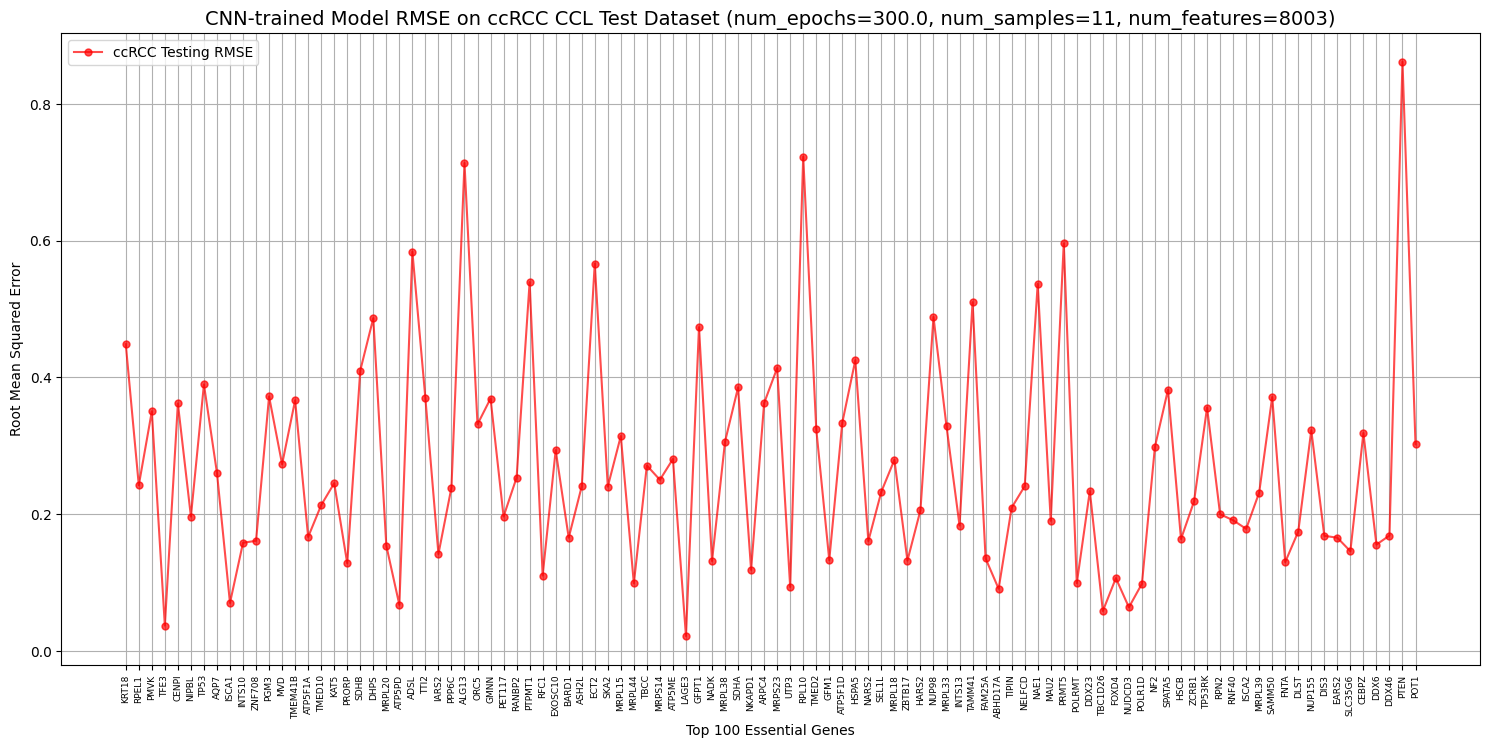

In [25]:
CNNFuncs.LinePlot(pred_RMSE_top100_essential_genes, 
            {"RMSE": "red"}, 
            axes_labels=["Top 100 Essential Genes", 
                         "Root Mean Squared Error"], 
            main_title="CNN-trained Model RMSE on {0} CCL Test Dataset (num_epochs={1}, num_samples={3}, num_features={2})".format(model_mode, num_epoch, X_train.shape[1], X_train.shape[0]),
            legend_titles={"RMSE": "{0} Testing RMSE".format(model_mode)})

In [26]:
print("Average RMSE for predicted gene effect scores on testing subset of CCLs: {0:.4}".format(pred_RMSE_top100_essential_genes["RMSE"].mean()))

Average RMSE for predicted gene effect scores on testing subset of CCLs: 0.2705


## Model Mode tRCC dataset

In [27]:
tRCC_predictions = pd.DataFrame(model.predict(tRCC_gene_exp), columns=tRCC_gene_exp.columns, index=tRCC_gene_exp.index)

1/1 [==============================] - 0s 17ms/step


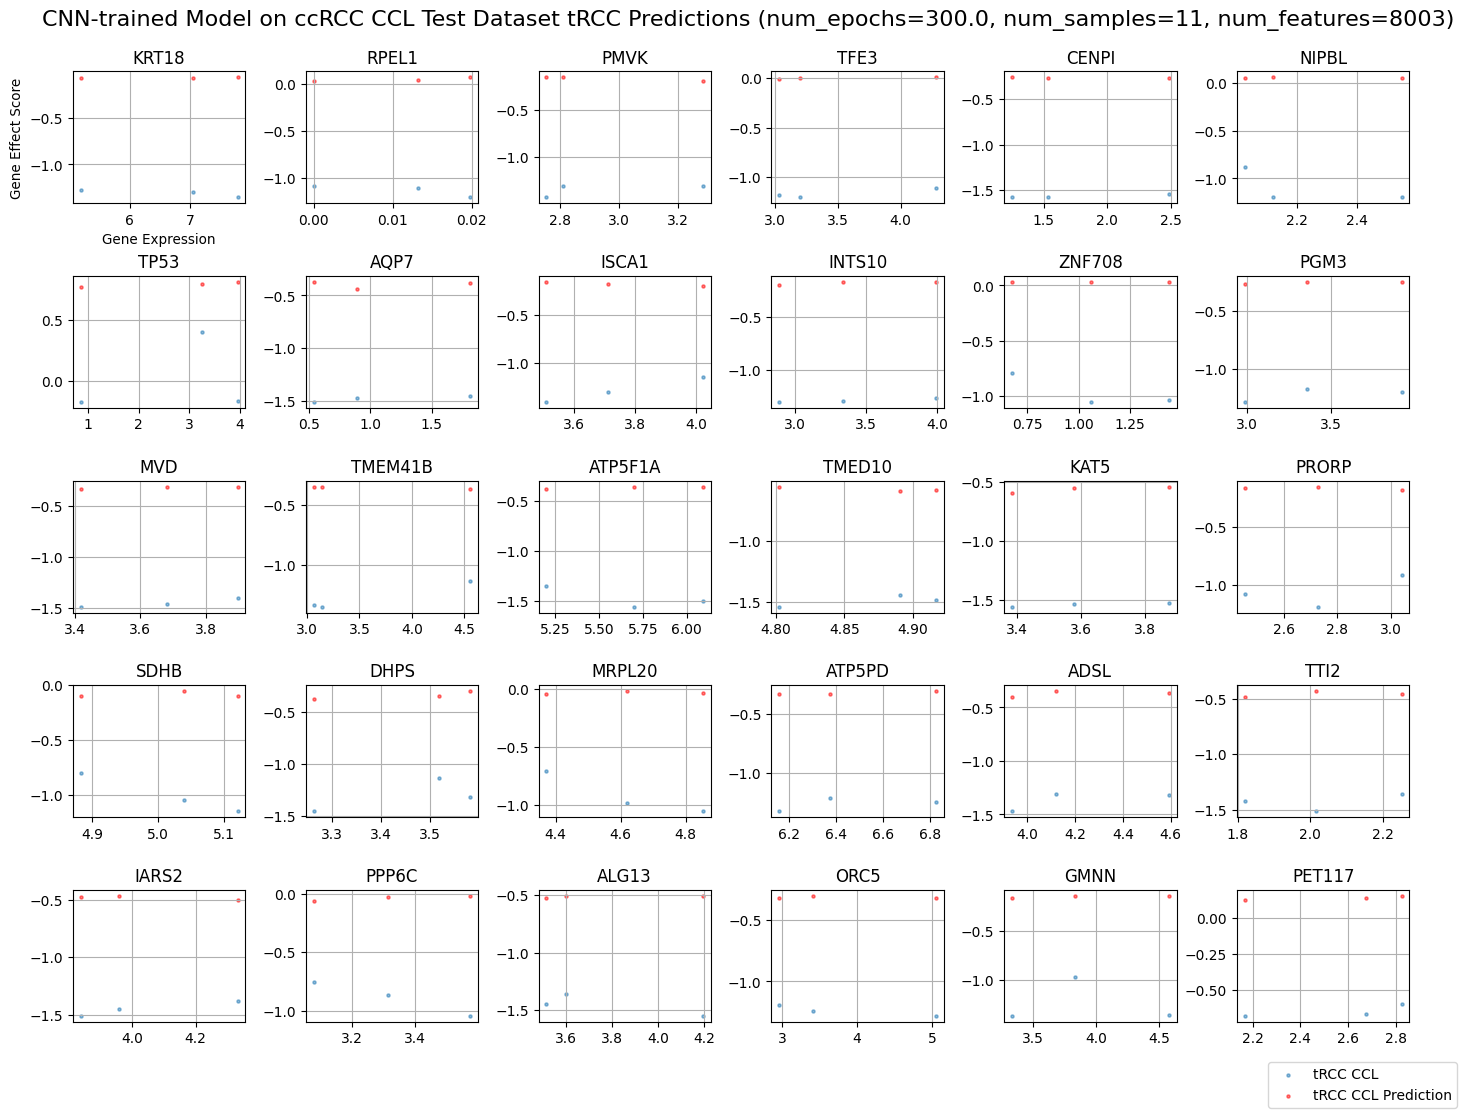

In [28]:
CNNFuncs.GeneRelMiniPlot(tRCC_gene_exp, tRCC_gene_effect, top100_essential_genes[:30].to_list(),
                         rel2_X=tRCC_gene_exp,
                         rel2_Y=tRCC_predictions,
                         main_title="CNN-trained Model on {0} CCL Test Dataset tRCC Predictions (num_epochs={1}, num_samples={3}, num_features={2})".format(model_mode, num_epoch, X_train.shape[1], X_train.shape[0]),
                         axes_labels=["Gene Expression", "Gene Effect Score"],
                         axis_label_fontsize=9.75,
                         legend_titles={"rel1": "tRCC CCL", "rel2": "tRCC CCL Prediction"},
                                        sizeProps=[0.925, 0.08, 0.99, 0],
                                        wspace=0.35,
                                        hspace=0.55)

In [32]:
tRCC_pred_RMSE_top100_essential_genes = CNNFuncs.PredGeneRMSE(tRCC_gene_effect, tRCC_predictions, top100_essential_genes)

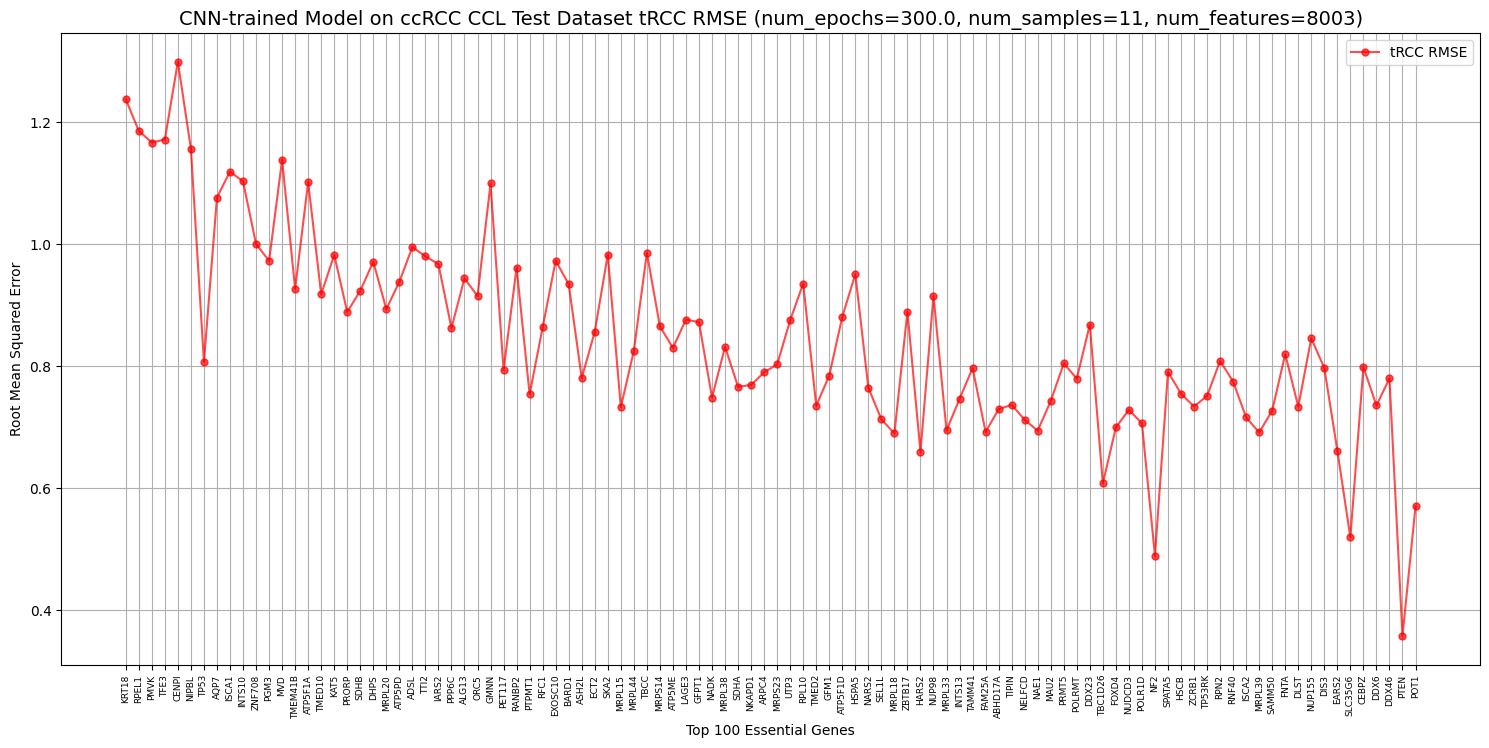

In [33]:
CNNFuncs.LinePlot(tRCC_pred_RMSE_top100_essential_genes, 
            {"RMSE": "red"}, 
            axes_labels=["Top 100 Essential Genes", 
                         "Root Mean Squared Error"], 
            main_title="CNN-trained Model on {0} CCL Test Dataset tRCC RMSE (num_epochs={1}, num_samples={3}, num_features={2})".format(model_mode, num_epoch, X_train.shape[1], X_train.shape[0]),
            legend_titles={"RMSE": "tRCC RMSE".format(model_mode)})

In [34]:
print("Average RMSE for predicted gene effect scores on tRCC CCLs: {0:.4}".format(tRCC_pred_RMSE_top100_essential_genes["RMSE"].mean()))

Average RMSE for predicted gene effect scores on tRCC CCLs: 0.8475
